In [1]:
# import matplotlib.pyplot as plt
import pyspark.sql.functions as f

from gentropy.common.session import Session
from gentropy.common.spark_helpers import order_array_of_structs_by_field
from gentropy.dataset.ld_index import LDIndex
from gentropy.dataset.study_index import StudyIndex
from gentropy.dataset.study_locus import StudyLocus
from gentropy.method.susie_inf import SUSIE_inf


Loading BokehJS ...

In [2]:
session = Session(
    extended_spark_conf={
        "spark.driver.memory": "10g",
        "spark.executor.memory": "10g",
    },
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/08/07 13:43:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/07 13:43:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/08/07 13:43:20 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


# Context

Gwas catalog studies with summary statistics were filtered using QC white-list  
Locus breaker clumping was performed on the resulting studies

Parameters:  
 lbc_baseline_pvalue: 1e-5,  
 lbc_distance_cutoff: 250_000,  
 lbc_pvalue_threshold: 1e-8,  
 lbc_flanking_distance: 100_000,  
 large_loci_size: 1_500_000,  
 wbc_clump_distance: 500_000,  
 wbc_pvalue_threshold: 1e-8,  
 collect_locus: bool = True,  
 remove_mhc: bool = True,

Loci with less than 100 variants, or more than 15,000, were filtered out and fine-mapped with PICS.


In [3]:
study_index = StudyIndex.from_parquet(
    session, "/Users/dc16/data/study_index/gwas_catalog/"
)
ld_index = LDIndex.from_parquet(session, "/Users/dc16/data/ld_index")
susie_loci = StudyLocus(
    session.spark.read.parquet("/Users/dc16/output/gwas_catalog/clean_loci.parquet"),
    StudyLocus.get_schema(),
)
pics_loci = StudyLocus(
    session.spark.read.parquet("/Users/dc16/output/gwas_catalog/filtered_loci.parquet"),
    StudyLocus.get_schema(),
)

24/08/07 13:45:02 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


## Susie fine mapping


Calculate the total number of unique studyIds


In [4]:
susie_loci.df.select("studyId").distinct().count()

Calculate the total number of loci for finemapping:


In [ ]:
susie_loci.df.count()

176096

In [ ]:
df = susie_loci.df.withColumns(
    {
        "locusSize": f.size("locus"),
        "locusLength": f.col("locusEnd") - f.col("locusStart"),
    }
)

In [ ]:
length = df.select(
    f.mean("locusLength").alias("meanLocusLength"),
    f.percentile_approx("locusLength", 0.25).alias("q1LocusLength"),
    f.percentile_approx("locusLength", 0.5).alias("medianLocusLength"),
    f.percentile_approx("locusLength", 0.75).alias("q3LocusLength"),
)
size = df.select(
    f.mean("locusSize").alias("meanLocusSize"),
    f.min("locusSize").alias("minLocusSize"),
    f.percentile_approx("locusSize", 0.25).alias("q1LocusSize"),
    f.percentile_approx("locusSize", 0.5).alias("medianLocusSize"),
    f.percentile_approx("locusSize", 0.75).alias("q3LocusSize"),
    f.max("locusSize").alias("maxLocusSize"),
)
length.show(vertical=True)
size.show(vertical=True)

-RECORD 0------------------------------
 meanLocusLength   | 682633.2350024986 
 q1LocusLength     | 327752            
 medianLocusLength | 517819            
 q3LocusLength     | 934946            



-RECORD 0-----------------------------
 meanLocusSize   | 3517.7594266763585 
 minLocusSize    | 100                
 q1LocusSize     | 1383               
 medianLocusSize | 2565               
 q3LocusSize     | 4859               
 maxLocusSize    | 15000              



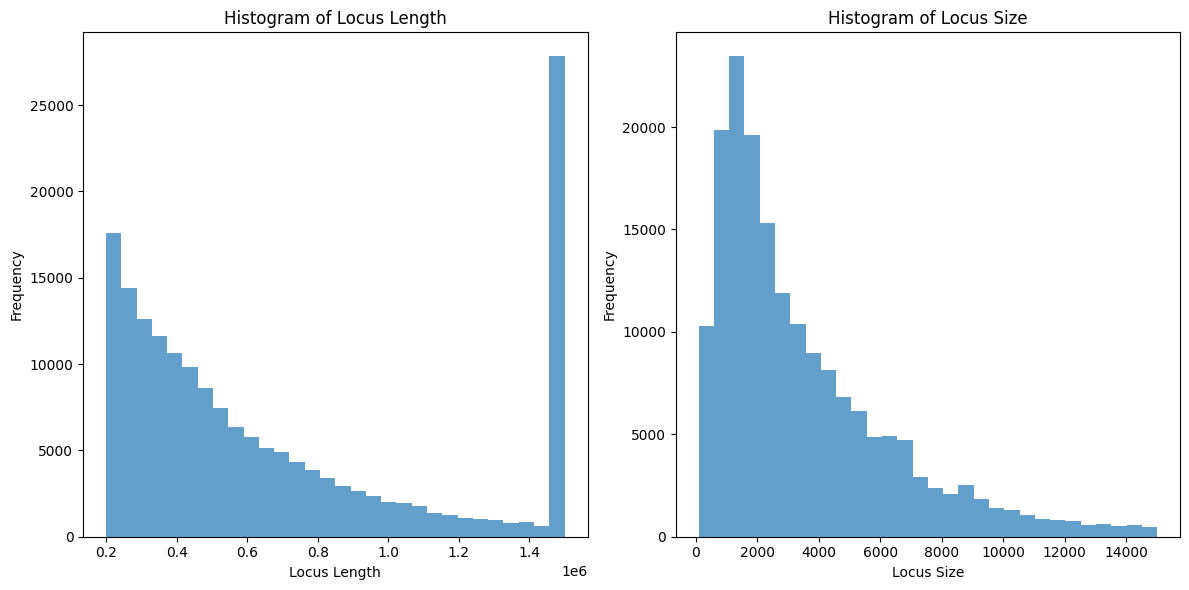

In [ ]:
panda_df = df.select("locusSize", "locusLength").toPandas()

# plt.figure(figsize=(12, 6))

# # Histogram for locusLength
# plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# plt.hist(panda_df["locusLength"], bins=30, alpha=0.7)
# plt.xlabel("Locus Length")
# plt.ylabel("Frequency")
# plt.title("Histogram of Locus Length")

# # Histogram for locusSize
# plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
# plt.hist(panda_df["locusSize"], bins=30, alpha=0.7)
# plt.xlabel("Locus Size")
# plt.ylabel("Frequency")
# plt.title("Histogram of Locus Size")

# plt.tight_layout()
# plt.show()

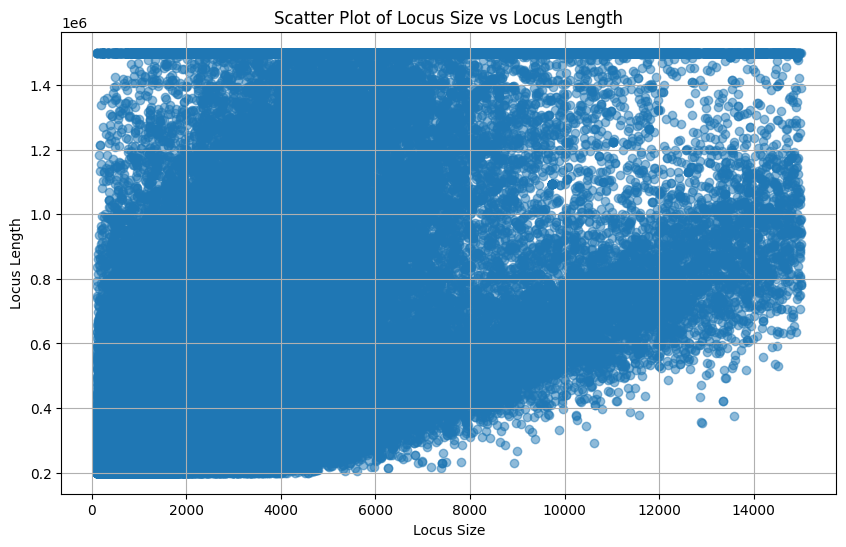

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.scatter(panda_df["locusSize"], panda_df["locusLength"], alpha=0.5)
# plt.title("Scatter Plot of Locus Size vs Locus Length")
# plt.xlabel("Locus Size")
# plt.ylabel("Locus Length")
# plt.grid(True)
# plt.show()

In [4]:
susie_fm = StudyLocus.from_parquet(session, "/Users/dc16/output/gwas_cat_fm")

Total credible sets:


In [5]:
susie_fm.df.count()

632123

It seems a very small fraction of loci have NaN assigned to values for their credible sets


In [6]:
nan = susie_fm.df.filter(f.isnan("credibleSetlog10BF"))
null = susie_fm.df.filter(f.isnull("credibleSetlog10BF"))

Number of credible sets with 'not a number' as the logBF:  39


Number of credible sets with 'null' as the logBF:  0


In [7]:
susie_results = (
    susie_fm.df.withColumn("credSetSize", f.size("locus"))
    .withColumn(
        "locus",
        f.slice(order_array_of_structs_by_field("locus", "posteriorProbability"), 1, 1)[
            0
        ],
    )
    .withColumn("topPP", f.col("locus").getField("posteriorProbability"))
    .filter(~f.isnan("topPP"))
)
(
    susie_results.select(
        f.mean("topPP").alias("meanTopPP"),
        f.min("topPP").alias("minTopPP"),
        f.percentile_approx("topPP", 0.25).alias("q1TopPP"),
        f.percentile_approx("topPP", 0.5).alias("medianTopPP"),
        f.percentile_approx("topPP", 0.75).alias("q3TopPP"),
        f.max("topPP").alias("maxTopPP"),
    ).show(vertical=True)
)
(
    susie_results.select(
        f.mean("credSetSize").alias("meanCredSetSize"),
        f.min("credSetSize").alias("minCredSetSize"),
        f.percentile_approx("credSetSize", 0.25).alias("q1CredSetSize"),
        f.percentile_approx("credSetSize", 0.5).alias("medianCredSetSize"),
        f.percentile_approx("credSetSize", 0.75).alias("q3CredSetSize"),
        f.max("credSetSize").alias("maxCredSetSize"),
    ).show(vertical=True)
)
(
    susie_results.select(
        f.mean("purityMeanR2").alias("meanPurityMeanR2"),
        f.min("purityMeanR2").alias("minPurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.25).alias("q1PurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.5).alias("medianPurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.75).alias("q3PurityMeanR2"),
        f.max("purityMeanR2").alias("maxPurityMeanR2"),
    ).show(vertical=True)
)
(
    susie_results.select(
        f.mean("purityMinR2").alias("meanPurityMinR2"),
        f.min("purityMinR2").alias("minPurityMinR2"),
        f.percentile_approx("purityMinR2", 0.25).alias("q1PurityMinR2"),
        f.percentile_approx("purityMinR2", 0.5).alias("medianPurityMinR2"),
        f.percentile_approx("purityMinR2", 0.75).alias("q3PurityMinR2"),
        f.max("purityMinR2").alias("maxPurityMinR2"),
    ).show(vertical=True)
)

-RECORD 0--------------------------
 meanTopPP   | 0.7341557442854078  
 minTopPP    | 5.30020287265377E-4 
 q1TopPP     | 0.43393218153901475 
 medianTopPP | 0.9841312727728387  
 q3TopPP     | 0.9999999999927383  
 maxTopPP    | 1.0                 



-RECORD 0------------------------------
 meanCredSetSize   | 64.33602495870802 
 minCredSetSize    | 1                 
 q1CredSetSize     | 1                 
 medianCredSetSize | 2                 
 q3CredSetSize     | 13                
 maxCredSetSize    | 10710             



-RECORD 0---------------------------------
 meanPurityMeanR2   | 0.6459716225861719  
 minPurityMeanR2    | 0.00469889394266767 
 q1PurityMeanR2     | 0.23746586177412243 
 medianPurityMeanR2 | 0.8203905763487525  
 q3PurityMeanR2     | 1.0                 
 maxPurityMeanR2    | 1.0                 



-RECORD 0---------------------------------
 meanPurityMinR2   | 0.48250211427144807  
 minPurityMinR2    | 0.0                  
 q1PurityMinR2     | 6.409217073028031... 
 medianPurityMinR2 | 0.46903358691552954  
 q3PurityMinR2     | 1.0                  
 maxPurityMinR2    | 1.0                  



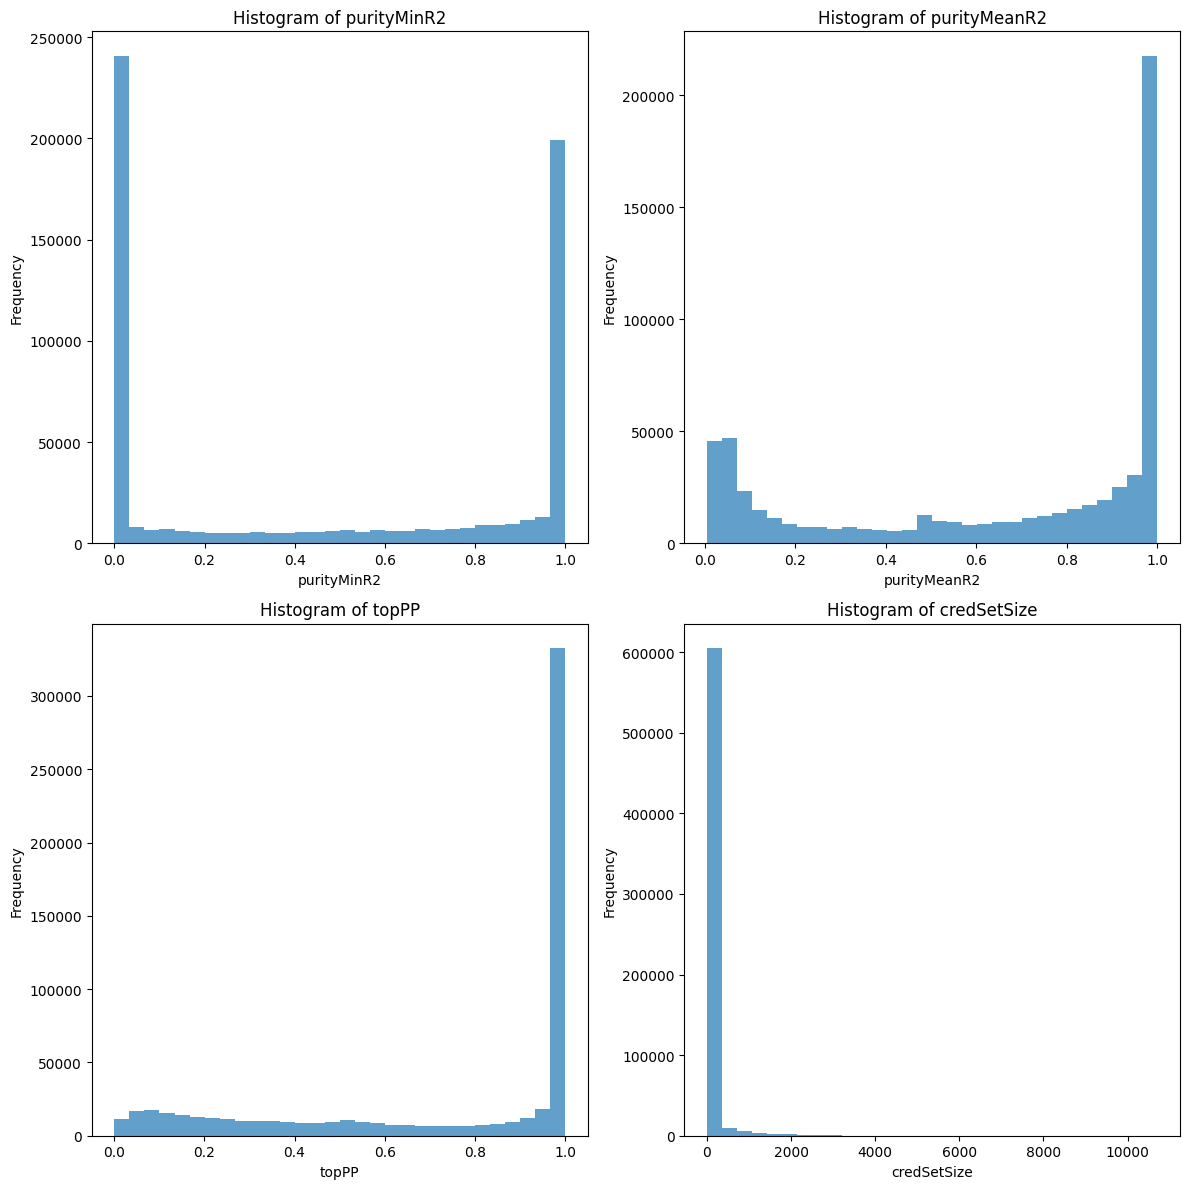

In [ ]:
pdf = susie_results.select("purityMinR2", "purityMeanR2", "topPP", "credSetSize").toPandas()
# plt.figure(figsize=(12, 12))

# # Histogram for purityMinR2
# plt.subplot(2, 2, 1)
# plt.hist(pdf["purityMinR2"], bins=30, alpha=0.7)
# plt.title("Histogram of purityMinR2")
# plt.xlabel("purityMinR2")
# plt.ylabel("Frequency")

# # Histogram for purityMeanR2
# plt.subplot(2, 2, 2)
# plt.hist(pdf["purityMeanR2"], bins=30, alpha=0.7)
# plt.title("Histogram of purityMeanR2")
# plt.xlabel("purityMeanR2")
# plt.ylabel("Frequency")

# # Histogram for topPP
# plt.subplot(2, 2, 3)
# plt.hist(pdf["topPP"], bins=30, alpha=0.7)
# plt.title("Histogram of topPP")
# plt.xlabel("topPP")
# plt.ylabel("Frequency")

# # Histogram for credSetSize
# plt.subplot(2, 2, 4)
# plt.hist(pdf["credSetSize"], bins=30, alpha=0.7)
# plt.title("Histogram of credSetSize")
# plt.xlabel("credSetSize")
# plt.ylabel("Frequency")

# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()

## Repeating the same steps, but filtering for only the first credible set

Total number of primary credible sets and number of unique studyIds:


In [ ]:
first_credset = susie_results.filter(f.col("credibleSetIndex") == 1)

Number of primary credible sets:  175991


Number of unique studyIds in primary credible sets:  5328


In [ ]:
(
    first_credset.select(
        f.mean("topPP").alias("meanTopPP"),
        f.min("topPP").alias("minTopPP"),
        f.percentile_approx("topPP", 0.25).alias("q1TopPP"),
        f.percentile_approx("topPP", 0.5).alias("medianTopPP"),
        f.percentile_approx("topPP", 0.75).alias("q3TopPP"),
        f.max("topPP").alias("maxTopPP"),
    ).show(vertical=True)
)
(
    first_credset.select(
        f.mean("credSetSize").alias("meanCredSetSize"),
        f.min("credSetSize").alias("minCredSetSize"),
        f.percentile_approx("credSetSize", 0.25).alias("q1CredSetSize"),
        f.percentile_approx("credSetSize", 0.5).alias("medianCredSetSize"),
        f.percentile_approx("credSetSize", 0.75).alias("q3CredSetSize"),
        f.max("credSetSize").alias("maxCredSetSize"),
    ).show(vertical=True)
)
(
    first_credset.select(
        f.mean("purityMeanR2").alias("meanPurityMeanR2"),
        f.min("purityMeanR2").alias("minPurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.25).alias("q1PurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.5).alias("medianPurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.75).alias("q3PurityMeanR2"),
        f.max("purityMeanR2").alias("maxPurityMeanR2"),
    ).show(vertical=True)
)
(
    first_credset.select(
        f.mean("purityMinR2").alias("meanPurityMinR2"),
        f.min("purityMinR2").alias("minPurityMinR2"),
        f.percentile_approx("purityMinR2", 0.25).alias("q1PurityMinR2"),
        f.percentile_approx("purityMinR2", 0.5).alias("medianPurityMinR2"),
        f.percentile_approx("purityMinR2", 0.75).alias("q3PurityMinR2"),
        f.max("purityMinR2").alias("maxPurityMinR2"),
    ).show(vertical=True)
)

-RECORD 0--------------------------
 meanTopPP   | 0.6268846688460689  
 minTopPP    | 5.30020287265377E-4 
 q1TopPP     | 0.22323522754002711 
 medianTopPP | 0.7547370350843897  
 q3TopPP     | 0.9999999999979536  
 maxTopPP    | 1.0                 



-RECORD 0------------------------------
 meanCredSetSize   | 50.48537709314681 
 minCredSetSize    | 1                 
 q1CredSetSize     | 1                 
 medianCredSetSize | 3                 
 q3CredSetSize     | 19                
 maxCredSetSize    | 10710             



-RECORD 0---------------------------------
 meanPurityMeanR2   | 0.674055454136671   
 minPurityMeanR2    | 0.00469889394266767 
 q1PurityMeanR2     | 0.3980306136489271  
 medianPurityMeanR2 | 0.8336824740390751  
 q3PurityMeanR2     | 0.9776068324678869  
 maxPurityMeanR2    | 1.0                 



-RECORD 0---------------------------------
 meanPurityMinR2   | 0.48629879351056204  
 minPurityMinR2    | 0.0                  
 q1PurityMinR2     | 3.997840337231423E-6 
 medianPurityMinR2 | 0.5018138600363721   
 q3PurityMinR2     | 0.9490123559383069   
 maxPurityMinR2    | 1.0                  



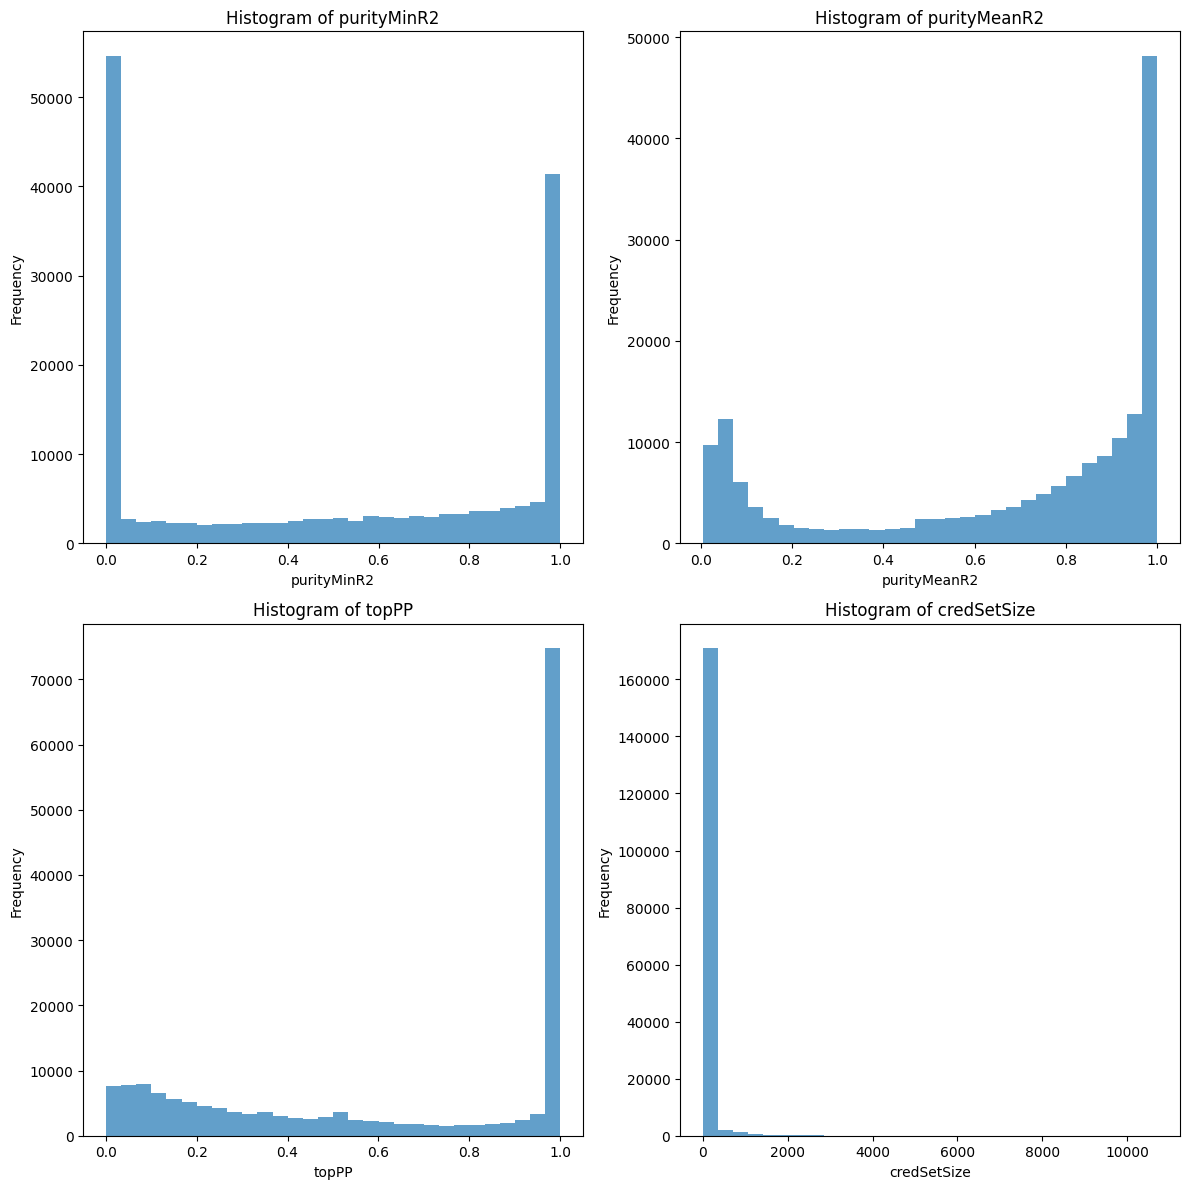

In [ ]:
pdf = first_credset.select("purityMinR2", "purityMeanR2", "topPP", "credSetSize").toPandas()
# plt.figure(figsize=(12, 12))

# # Histogram for purityMinR2
# plt.subplot(2, 2, 1)
# plt.hist(pdf["purityMinR2"], bins=30, alpha=0.7)
# plt.title("Histogram of purityMinR2")
# plt.xlabel("purityMinR2")
# plt.ylabel("Frequency")

# # Histogram for purityMeanR2
# plt.subplot(2, 2, 2)
# plt.hist(pdf["purityMeanR2"], bins=30, alpha=0.7)
# plt.title("Histogram of purityMeanR2")
# plt.xlabel("purityMeanR2")
# plt.ylabel("Frequency")

# # Histogram for topPP
# plt.subplot(2, 2, 3)
# plt.hist(pdf["topPP"], bins=30, alpha=0.7)
# plt.title("Histogram of topPP")
# plt.xlabel("topPP")
# plt.ylabel("Frequency")

# # Histogram for credSetSize
# plt.subplot(2, 2, 4)
# plt.hist(pdf["credSetSize"], bins=30, alpha=0.7)
# plt.title("Histogram of credSetSize")
# plt.xlabel("credSetSize")
# plt.ylabel("Frequency")

# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()

# Filtering credible sets with qc function

In [8]:
qc_credsets = SUSIE_inf.credible_set_qc(
    susie_fm, study_index, ld_index, 1e-5, 0.25, 0.8
).persist()

qc_credsets = (
    qc_credsets.df.withColumn("credSetSize", f.size("locus"))
    .withColumn(
        "locus",
        f.slice(order_array_of_structs_by_field("locus", "posteriorProbability"), 1, 1)[
            0
        ],
    )
    .withColumn("topPP", f.col("locus").getField("posteriorProbability"))
    .filter(~f.isnan("topPP"))
)


24/08/07 13:49:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Number of high quality credible sets:  220670
Number of unique studyIds in high quality credible sets:  4862


In [ ]:
(
    qc_credsets.select(
        f.mean("topPP").alias("meanTopPP"),
        f.min("topPP").alias("minTopPP"),
        f.percentile_approx("topPP", 0.25).alias("q1TopPP"),
        f.percentile_approx("topPP", 0.5).alias("medianTopPP"),
        f.percentile_approx("topPP", 0.75).alias("q3TopPP"),
        f.max("topPP").alias("maxTopPP"),
    ).show(vertical=True)
)
(
    qc_credsets.select(
        f.mean("credSetSize").alias("meanCredSetSize"),
        f.min("credSetSize").alias("minCredSetSize"),
        f.percentile_approx("credSetSize", 0.25).alias("q1CredSetSize"),
        f.percentile_approx("credSetSize", 0.5).alias("medianCredSetSize"),
        f.percentile_approx("credSetSize", 0.75).alias("q3CredSetSize"),
        f.max("credSetSize").alias("maxCredSetSize"),
    ).show(vertical=True)
)
(
    qc_credsets.select(
        f.mean("purityMeanR2").alias("meanPurityMeanR2"),
        f.min("purityMeanR2").alias("minPurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.25).alias("q1PurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.5).alias("medianPurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.75).alias("q3PurityMeanR2"),
        f.max("purityMeanR2").alias("maxPurityMeanR2"),
    ).show(vertical=True)
)
(
    qc_credsets.select(
        f.mean("purityMinR2").alias("meanPurityMinR2"),
        f.min("purityMinR2").alias("minPurityMinR2"),
        f.percentile_approx("purityMinR2", 0.25).alias("q1PurityMinR2"),
        f.percentile_approx("purityMinR2", 0.5).alias("medianPurityMinR2"),
        f.percentile_approx("purityMinR2", 0.75).alias("q3PurityMinR2"),
        f.max("purityMinR2").alias("maxPurityMinR2"),
    ).show(vertical=True)
)

-RECORD 0---------------------------
 meanTopPP   | 0.7351960328222914   
 minTopPP    | 0.002487989359821... 
 q1TopPP     | 0.4347870006604458   
 medianTopPP | 0.9884991069860085   
 q3TopPP     | 0.9999999989221352   
 maxTopPP    | 1.0                  

-RECORD 0------------------------------
 meanCredSetSize   | 11.30863667991574 
 minCredSetSize    | 1                 
 q1CredSetSize     | 1                 
 medianCredSetSize | 2                 
 q3CredSetSize     | 8                 
 maxCredSetSize    | 2681              



-RECORD 0--------------------------------
 meanPurityMeanR2   | 0.9362013839231683 
 minPurityMeanR2    | 0.50525100583065   
 q1PurityMeanR2     | 0.8961545002734692 
 medianPurityMeanR2 | 0.991509701456222  
 q3PurityMeanR2     | 1.0                
 maxPurityMeanR2    | 1.0                



-RECORD 0--------------------------------
 meanPurityMinR2   | 0.8346683610862959  
 minPurityMinR2    | 0.25001241379266637 
 q1PurityMinR2     | 0.6919444964125268  
 medianPurityMinR2 | 0.9832675585945014  
 q3PurityMinR2     | 1.0                 
 maxPurityMinR2    | 1.0                 



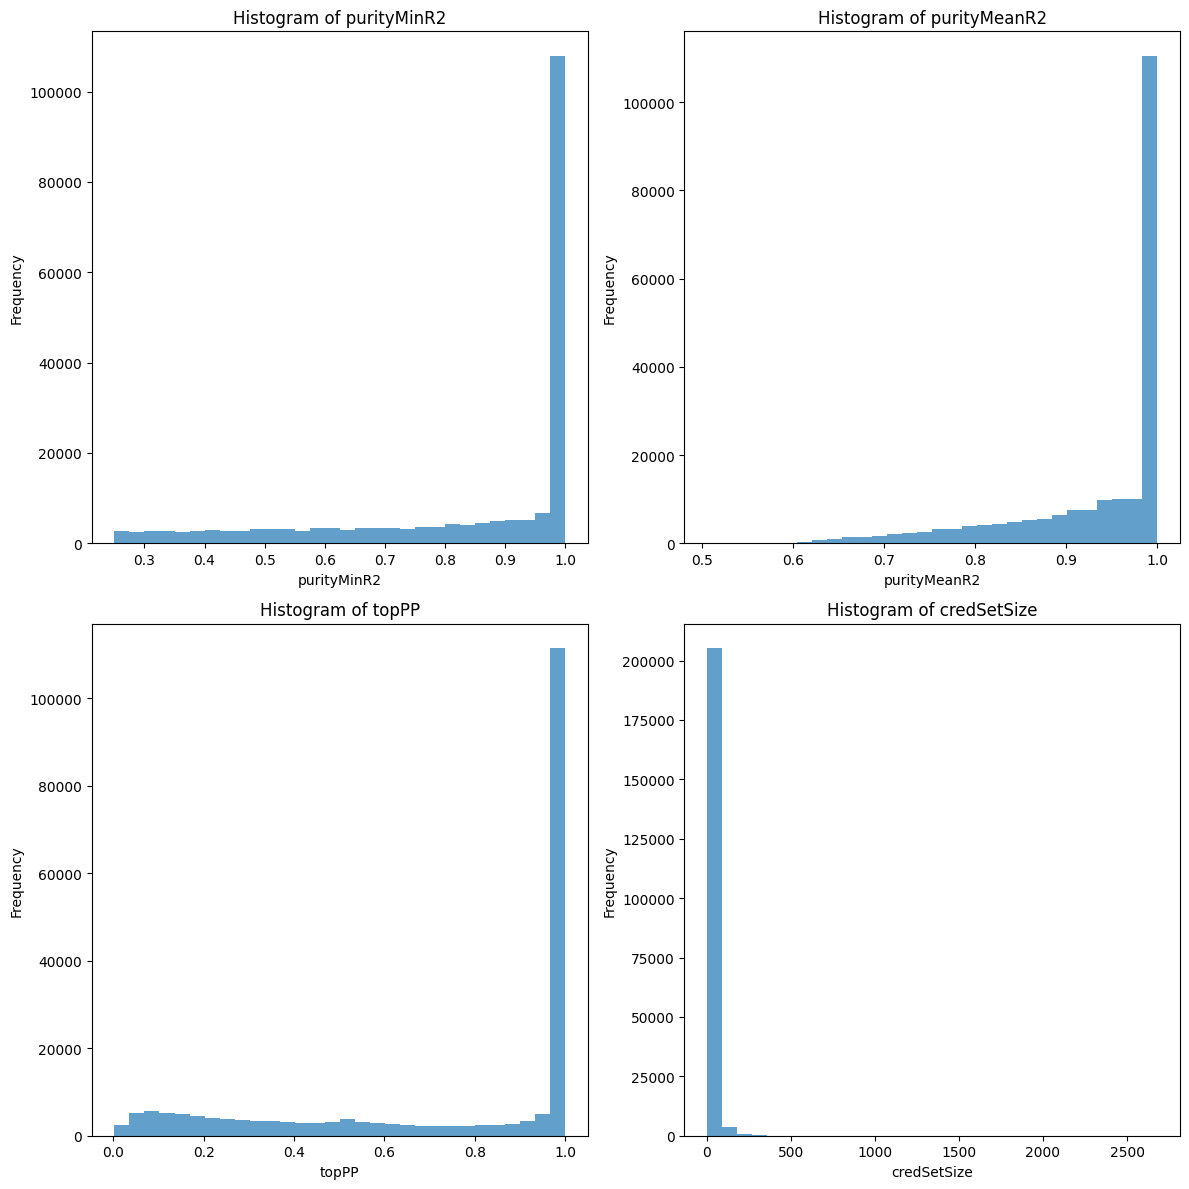

In [ ]:
pdf = qc_credsets.select("purityMinR2", "purityMeanR2", "topPP", "credSetSize").toPandas()
# plt.figure(figsize=(12, 12))

# # Histogram for purityMinR2
# plt.subplot(2, 2, 1)
# plt.hist(pdf["purityMinR2"], bins=30, alpha=0.7)
# plt.title("Histogram of purityMinR2")
# plt.xlabel("purityMinR2")
# plt.ylabel("Frequency")

# # Histogram for purityMeanR2
# plt.subplot(2, 2, 2)
# plt.hist(pdf["purityMeanR2"], bins=30, alpha=0.7)
# plt.title("Histogram of purityMeanR2")
# plt.xlabel("purityMeanR2")
# plt.ylabel("Frequency")

# # Histogram for topPP
# plt.subplot(2, 2, 3)
# plt.hist(pdf["topPP"], bins=30, alpha=0.7)
# plt.title("Histogram of topPP")
# plt.xlabel("topPP")
# plt.ylabel("Frequency")

# # Histogram for credSetSize
# plt.subplot(2, 2, 4)
# plt.hist(pdf["credSetSize"], bins=30, alpha=0.7)
# plt.title("Histogram of credSetSize")
# plt.xlabel("credSetSize")
# plt.ylabel("Frequency")

# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()

# WIP

# Clumped loci filtered for usage with PICS


Number of unique studyIds


In [ ]:
pics_loci.df.select("studyId").distinct().count()

231

Number of loci to fine map with PICS


In [ ]:
pics_loci.df.count()

9990

In [ ]:
df = pics_loci.df.withColumns(
    {
        "locusSize": f.size("locus"),
        "locusLength": f.col("locusEnd") - f.col("locusStart"),
    }
)

How many loci with less than 100 variants from summary statistics?


In [ ]:
df.filter(f.col("locusSize") < 100).count()

985

How many loci with more than 15,000 variants from summary statistics?


In [ ]:
df.filter(f.col("locusSize") > 15_000).count()

9005

In [ ]:
length = df.select(
    f.mean("locusLength").alias("meanLocusLength"),
    f.percentile_approx("locusLength", 0.25).alias("q1LocusLength"),
    f.percentile_approx("locusLength", 0.5).alias("medianLocusLength"),
    f.percentile_approx("locusLength", 0.75).alias("q3LocusLength"),
)
size = df.select(
    f.mean("locusSize").alias("meanLocusSize"),
    f.min("locusSize").alias("minLocusSize"),
    f.percentile_approx("locusSize", 0.25).alias("q1LocusSize"),
    f.percentile_approx("locusSize", 0.5).alias("medianLocusSize"),
    f.percentile_approx("locusSize", 0.75).alias("q3LocusSize"),
    f.max("locusSize").alias("maxLocusSize"),
)
length.show(vertical=True)
size.show(vertical=True)

-RECORD 0------------------------------
 meanLocusLength   | 1294768.356956957 
 q1LocusLength     | 1231357           
 medianLocusLength | 1500000           
 q3LocusLength     | 1500000           



-RECORD 0-----------------------------
 meanLocusSize   | 18537.992992992993 
 minLocusSize    | 1                  
 q1LocusSize     | 16779              
 medianLocusSize | 19456              
 q3LocusSize     | 22436              
 maxLocusSize    | 39972              



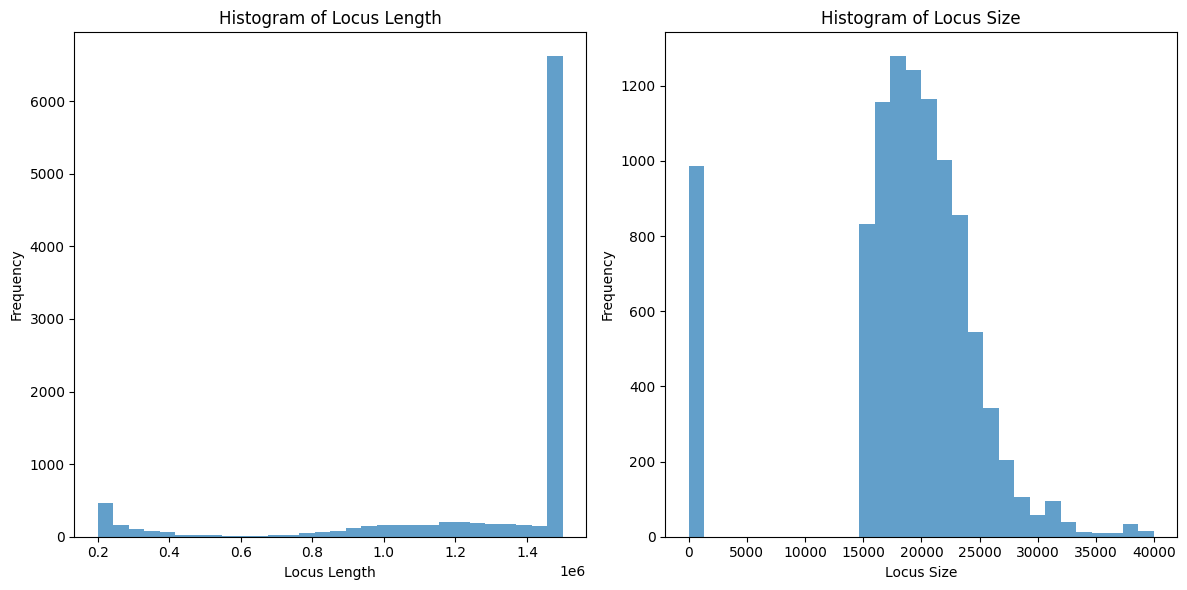

In [ ]:
panda_df = df.select("locusSize", "locusLength").toPandas()

# plt.figure(figsize=(12, 6))

# # Histogram for locusLength
# plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# plt.hist(panda_df["locusLength"], bins=30, alpha=0.7)
# plt.xlabel("Locus Length")
# plt.ylabel("Frequency")
# plt.title("Histogram of Locus Length")

# # Histogram for locusSize
# plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
# plt.hist(panda_df["locusSize"], bins=30, alpha=0.7)
# plt.xlabel("Locus Size")
# plt.ylabel("Frequency")
# plt.title("Histogram of Locus Size")

# plt.tight_layout()
# plt.show()

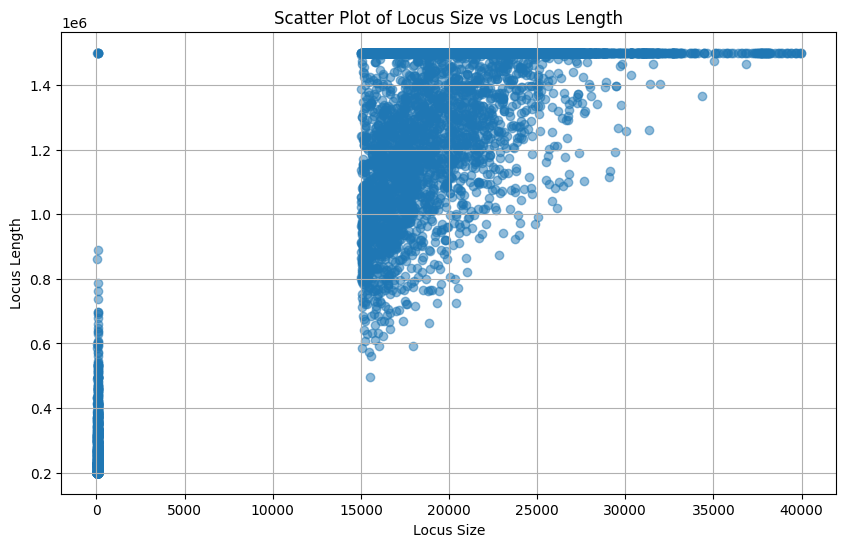

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.scatter(panda_df["locusSize"], panda_df["locusLength"], alpha=0.5)
# plt.title("Scatter Plot of Locus Size vs Locus Length")
# plt.xlabel("Locus Size")
# plt.ylabel("Locus Length")
# plt.grid(True)
# plt.show()